## Cluster Analysis for Clinical Implications (DDR Tree, MDS)
* Sangwon Baek
* March 10th, 2023

In [1]:
import pandas as pd
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, norm, mannwhitneyu, chi2_contingency, fisher_exact, ttest_ind, zscore

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, ParameterGrid, StratifiedKFold, KFold
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from statsmodels.stats.proportion import proportion_confint

from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import statsmodels.api as sm

import dynamo
import networkx as nx
import pickle
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from matplotlib import gridspec
import matplotlib.patches as patches

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.neighbors import KernelDensity

C:\Users\user\anaconda3\envs\DDRTree\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\user\anaconda3\envs\DDRTree\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\user\anaconda3\envs\DDRTree\Lib\site-packages\umap\distances.py:1086: NumbaDepr

In [2]:
#Read csv file using pandas
df2 = pd.read_csv('../Data/Preprocessed/CRF_Initial.csv', low_memory=False)
df2 = df2.drop(columns='Unnamed: 0')

na_cols = ['UD_HT','UD_DM','UD_CVD','UD_cancer','UD_other','SMT_fever','SMT_cough','SMT_sputum','SMT_dyspnea',
          'SMT_myalgia', 'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'steroid']
df2[na_cols] = df2[na_cols].fillna(value=0)

#Remove D-Dimer from the dataframe
ColumnNames = ['No', 'ID', 'age', 'sex', 'dx_date', 'hospitalized_date', 'UD_HT', 'UD_DM', 'UD_CVD', 'UD_cancer',
              'UD_other', 'SMT_fever', 'SMT_cough', 'SMT_sputum', 'SMT_dyspnea', 'SMT_myalgia',
              'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'TX_0', 'TX_1', 'TX_2', 'TX_3', 'TX_4', 
               'Smoking_0', 'Smoking_1', 'Smoking_2', 'Smoking_3', 'BT', 'SBP', 
               'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH', 
               'DD', 'PCR', 'steroid', 'Mild','Moderate','Severe']
df2 = df2[ColumnNames].drop(columns = 'DD')

#Replace names of UD and SMT without them. 
# Replace 'UD_' and 'SMT_' in the column names
new_column_names = {col: col.replace('UD_', '').replace('SMT_', '') for col in df2.columns}

# Rename the columns in the dataframe
df2 = df2.rename(columns=new_column_names)

#Separate DF into validation and developmentsets
DevelopmentSet = df2.loc[~df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
ValidationSet = df2.loc[df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]

### Data Conversion / Normalization / Train Test Split

In [3]:
def data_preprocessor(train_dataset, test_dataset, columnList, outcome):
    #Create train and test set
    X_train = train_dataset[columnList].values
    X_test = test_dataset[columnList].values
    Y_train = train_dataset[outcome].values.ravel()
    Y_test = test_dataset[outcome].values.ravel()
    
    #Apply StandardScaler Normalization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    return X_train, X_test, Y_train, Y_test

def Compute_CI(values):    
    sample_mean = np.mean(values)
    # ddof=1 to compute sample standard deviation
    sample_std = np.std(values, ddof=1) 
    
    # for a 95% confidence interval
    z_value = norm.ppf(0.975)  
    ci_lower = sample_mean - z_value * (sample_std / np.sqrt(len(values)))
    ci_upper = sample_mean + z_value * (sample_std / np.sqrt(len(values)))
    return [ci_lower, ci_upper]

In [4]:
#List of Columns 
outcome = ['Severe']
#ALL Variables
Variables_0 = ['age', 'sex', 'HT', 'DM', 'CVD', 'cancer', 'other',
               'fever', 'cough', 'sputum', 'dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI', 
               'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']

#Select the variables that commonly appear among 6 selection techniques based on selection probability.
#Available Selection Probabilities exceeding 50%  
#{1}_{2}_{3}_V{4} : 1=Selection Probability, 2=Top cutoff, 3=Variable Numbers, 4=Version when same (default: 1)

#5
Variables_1 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR']
Variables_2 = ['CRP', 'LDH', 'ALC', 'ANC', 'dyspnea']

#6
Variables_3 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea']
Variables_4 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'WBC']
Variables_5 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'PLT']

#7 
Variables_6 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC']
Variables_7 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'PLT']
Variables_8 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'SPO2']

#8
Variables_9 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age']
Variables_10 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2']
Variables_11 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'DBP']

#9
Variables_12 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2']
Variables_13 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP']
Variables_14 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PR']
Variables_15 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'BT']

#10
Variables_16 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']
Variables_17 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PR']
Variables_18 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT']
Variables_19 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP']
Variables_20 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM']
Variables_21 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT']
Variables_22 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']

#11
Variables_23 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PR']
Variables_24 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'BT']
Variables_25 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP']
Variables_26 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'DM']
Variables_27 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT']
Variables_28 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'BT']
Variables_29 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'SBP']
Variables_30 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'DM']
Variables_31 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'PLT']
Variables_32 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DBP']
Variables_33 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'PR']
Variables_34 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SBP']
Variables_35 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DM']
Variables_36 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SPO2']
Variables_37 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'PR']
Variables_38 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'BT']
Variables_39 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP']
Variables_40 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DM']
Variables_41 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DBP']
Variables_42 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PR']
Variables_43 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'DM']
Variables_44 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PLT']
Variables_45 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'PR']
Variables_46 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'DM']
Variables_47 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'SBP']
Variables_48 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM', 'PR']
Variables_49 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'PR']
Variables_50 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'DM']

#12
Variables_51 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'BT']
Variables_52 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'SBP']
Variables_53 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'DM']
Variables_54 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'PR']
Variables_55 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'BT']
Variables_56 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'DM']
Variables_57 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'PR']
Variables_58 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'BT']
Variables_59 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'PLT']

#13
Variables_60 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP','DM', 'BT']

Num_Variables = 60

In [5]:
#Preprocess dataset based on columnList
for i in range (Num_Variables):
    exec(f"X{i}_train, X{i}_test, Y{i}_train, Y{i}_test = data_preprocessor(DevelopmentSet, ValidationSet, Variables_{i}, outcome)")

#### Preprocessing the dataset

In [6]:
#Convert hospitalized date to datetime object
df2.hospitalized_date = pd.to_datetime(df2.hospitalized_date)

#Create variant column and assign 'alpha', 'delta', 'omicron' accordingly
for index, row in df2.iterrows():
    hospitalized_date = row['hospitalized_date']
    #2020 January to 2021 April
    if hospitalized_date >= pd.to_datetime('2020-01-01') and hospitalized_date < pd.to_datetime('2021-05-06'):
        df2.at[index, 'variant'] = 'Original-Alpha'
    #2021 April to 2021 December
    elif hospitalized_date >= pd.to_datetime('2021-05-06') and hospitalized_date < pd.to_datetime('2021-11-24'):
        df2.at[index, 'variant'] = 'Delta'
    #2021 November to 2022 
    elif hospitalized_date >= pd.to_datetime('2021-11-24') and hospitalized_date < pd.to_datetime('2022-10-31'):
        df2.at[index, 'variant'] = 'Omicron' 
        
Variant_Variables = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DM', 'variant']
FinalAll = df2[Variant_Variables].copy()

In [7]:
# Apply log transformation
for col in ['CRP', 'LDH', 'ALC', 'ANC', 'WBC', 'PLT', 'RR','SPO2']:
    FinalAll.loc[:, col] = np.log1p(FinalAll[col])

# Create a new dataframe for outlier identification
outliers = pd.DataFrame()

# Identify and label outliers
for col in ['CRP', 'LDH', 'ALC', 'ANC', 'WBC', 'PLT', 'RR','SPO2']:
    lower = FinalAll[col].quantile(0.02)
    upper = FinalAll[col].quantile(0.98)
    outliers[col] = (FinalAll[col] < lower) | (FinalAll[col] > upper)

# Convert True to 1 and False to 0
outliers = outliers.astype(int)

# Add a new column 'any_outlier' that is 1 if any column in a row has 1, else 0
outliers['any_outlier'] = outliers.any(axis=1).astype(int)

# Now, let's filter FinalAll dataframe to include only rows that are not outliers
FinalAll_no_outliers = FinalAll.loc[outliers['any_outlier'] == 0].copy()

# Apply expm1 transformation to reverse the log transformation
for col in ['CRP', 'LDH', 'ALC', 'ANC', 'WBC', 'PLT', 'RR','SPO2']:
    FinalAll_no_outliers.loc[:, col] = np.expm1(FinalAll_no_outliers[col])

In [8]:
# scale the data
scaler = StandardScaler()

continuous_cols = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'WBC', 'age', 'SPO2', 'PLT']

# Scale only the continuous variables
temp = FinalAll_no_outliers.copy()
temp[continuous_cols] = scaler.fit_transform(temp[continuous_cols])
FinalAll_no_outliers_scaled = temp

# Principal component analysis 
pca = PCA()
principalComponents = pca.fit_transform(FinalAll_no_outliers_scaled.drop(columns=['variant']))

# Compute expained variance variance
explained_variance = pca.explained_variance_ratio_

# calculate the cumulative sum of explained variances
cum_explained_variance = np.cumsum(explained_variance)

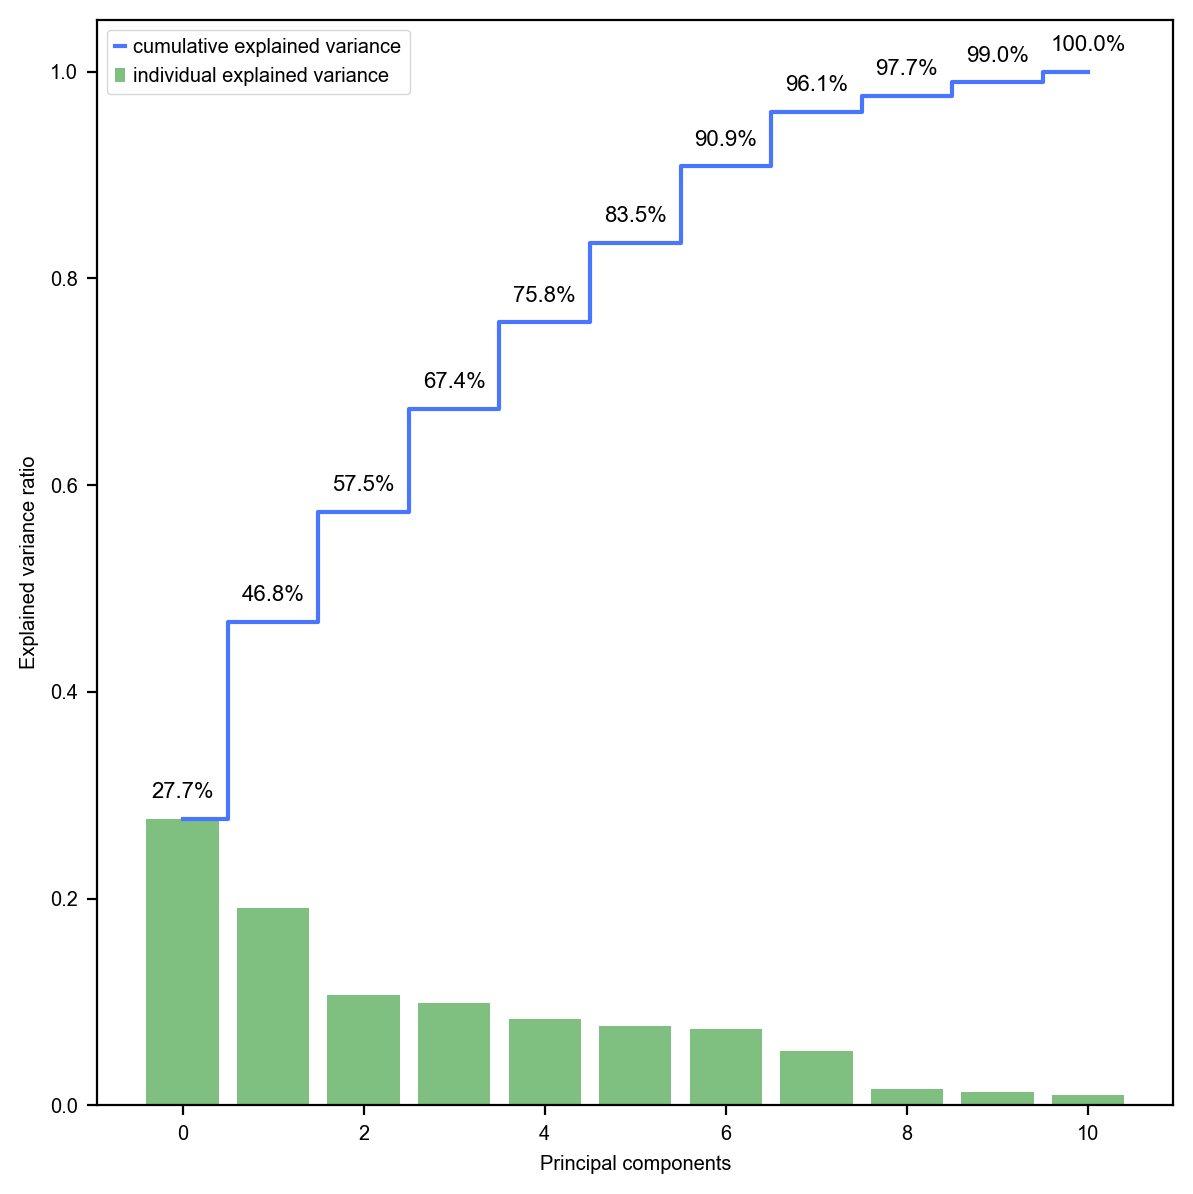

In [9]:
# plot the explained variance ratio and cumulative sum
plt.figure(figsize=(6, 6))

# Create the bar plot for each component's explained variance
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center', 
        label='individual explained variance', color = 'g')

# Create a step plot for the cumulative explained variance
plt.step(range(len(cum_explained_variance)), cum_explained_variance, where='mid', 
         label='cumulative explained variance')

# Add percentage to the cumulative sum plot
for i, j in enumerate(cum_explained_variance):
    plt.text(i, j+0.02, str(round(j*100, 1)) + '%', ha='center')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### DDR Tree Plot

In [10]:
def DNN_Model_Development(X_development, Y_development):
    #Define random_state
    random_state = 0 
    
    #Split the development dataset into train and test set (random_state = constant) 
    X_train, X_val, Y_train, Y_val = train_test_split(X_development, Y_development, test_size=0.2, random_state=random_state, stratify=Y_development)

    #Reset Tensorflow
    np.random.seed(random_state)
    rn.seed(random_state)
    tf.random.set_seed(random_state)
    tf.compat.v1.set_random_seed(random_state)
    tf.keras.initializers.Zeros()
    
    #Define earlyStopping, lr_scheduler
    earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)

    #DNN Final Model Building with 8:2 validation datset 
    model = Sequential([
        keras.layers.Dense(128, input_shape = (X_development.shape[1],), activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"])

    #Use X_train, Y_train for model training | X_val, Y_val for model evaluation during development process
    model.fit(X_train, Y_train, validation_data = (X_val, Y_val), verbose = 0, epochs=50, batch_size=32, 
              callbacks = [lr_scheduler, earlyStopping])

    return model

def get_residuals(df_DDR, lab_vars):
    residuals = pd.DataFrame(index=df_DDR.index)
    
    for lab in lab_vars:
        # Define your dependent variable
        y = df_DDR[lab]

        # Define your independent variables
        X = df_DDR[['age', 'DM', 'dyspnea']]

        # Add constant to the independent variables matrix
        X = sm.add_constant(X)

        # Fit the model
        model = sm.OLS(y, X)
        results = model.fit()

        # Compute and store residuals
        residuals[lab] = results.resid
    return residuals

In [11]:
numbers = [40]
for i in numbers:
    # DNN parameter: {Layers: 128 -> 32 -> 10 -> 1, Dropout: 0.3, BatchNormalization, EarlyStopper (Patience=5), LR_scheduler (factor=0.7, Patience=2)}
    exec(f"DNN_model_{i} = DNN_Model_Development(X{i}_train, Y{i}_train)")

Epoch 9: early stopping


In [12]:
# # Define the values of sigma and gamma that you want to try
# # sigma_values = [0.01, 0.02, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.08, 0.09, 0.1]
# sigma_values = [0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.08, 0.09, 0.1]
# gamma_values = [0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

# # Create an empty DataFrame to store the sigma and gamma values
# parameter_df = pd.DataFrame(columns=["count", "sigma", "gamma"])

# # Tune the DDR Trees with multiple test values of sigma and gamma
# count = 70
# for sigma in sigma_values:
#     for gamma in gamma_values:
#         exec(f"DDR_Tree_{count} = dynamo.tl.DDRTree(Df_Without_Outliers.T, maxIter=5, sigma=sigma, gamma=gamma)")
        
#         # Add the sigma and gamma values to the DataFrame
#         parameter_df.loc[count] = [count, sigma, gamma]
        
#         # Save the DDR_Tree object as picklet file
#         with open(f'DDRTree/DDR_Tree_{count}.pkl', 'wb') as f:
#             exec(f"pickle.dump(DDR_Tree_{count}, f)") 
        
#         # Add the count
#         count+=1
        
# import os 

# # Get a list of all DDR_Tree pickle files in the 'DDRTree' directory
# filenames = os.listdir('DDRTree')

# count = 0
# # Loop through all the filenames
# for filename in filenames:
#     # Ensure the file is a .pkl file
#     if filename.endswith('.pkl'):
#         # Open the file in read-binary mode
#         with open(f'DDRTree/{filename}', 'rb') as f:
#             exec(f"DDR_Tree_{count} = pickle.load(f)")
#             count+=1

In [13]:
#Create instance without outliers & Transformed already
Df_Without_Outliers = FinalAll_no_outliers_scaled.copy().drop(columns=['variant'])

# Get the final DDR Tree after tuning with multiple sigma and gamma values - least branches with most rigid tree structure was selected
DDR_Tree_Final = dynamo.tl.DDRTree(Df_Without_Outliers.T, maxIter=5, sigma=0.03, gamma=0.007)

iter =  0 obj =  4781.30908997238
iter =  1 obj =  4747.0177386350115
iter =  2 obj =  4746.130433697875
iter =  3 obj =  4745.933998132404
iter =  4 obj =  4745.859439551568


In [14]:
#Instantiate DDR without outliers
Df_DDR_Without_Outliers = pd.DataFrame(Df_Without_Outliers, columns = Variables_40)

# Obtain probabilities of severity with outliers
severity_proba_Without_Outliers = DNN_model_40.predict(Df_Without_Outliers)

# Add probabilities to the dataframe
Df_DDR_Without_Outliers['severity_proba'] = severity_proba_Without_Outliers

# One-hot encoding age by setting age > 60 as 1, age <= 60 as 0
Df_DDR_Without_Outliers['age_category'] = FinalAll_no_outliers['age'].apply(lambda x: 1 if x > 65 else 0)

# Convert 'DM', 'dyspnea', and 'age_category' columns to integer type
Df_DDR_Without_Outliers['DM'] = Df_DDR_Without_Outliers['DM'].astype(int)
Df_DDR_Without_Outliers['dyspnea'] = Df_DDR_Without_Outliers['dyspnea'].astype(int)
Df_DDR_Without_Outliers['age_category'] = Df_DDR_Without_Outliers['age_category'].astype(int)

150/150 [==============================] - 0s 490us/step


In [157]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    length = len(value)
    return tuple(int(value[i:i+length//3], 16)/255 for i in range(0, length, length//3))

def plot_DDR_color(DDR, residuals, column_names, jitter, alpha_level, point_size):
    # Unpack DDRTree's output
    Z, Y_orig, stree, R, W, Q, C, objs = DDR

    # Copy Y to avoid modifying the original data
    Y = Y_orig.copy()
    
    # Transpose Y for easier plotting
    Y = Y.T
    
    # Add some random noise ("jitter") to the Y values for visualization purposes
    Y += np.random.normal(0, jitter, Y.shape)

    # Define color 
    #dark red to light green
    # color_list = ['#B6DA4D', '#8C362A']
    
    #dark blue to light green 
    color_list = ['#9DD20F', '#001173']
    
    # Create a colormap from color list
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", color_list, N=256)

    # Define normalization to map residuals to the color map
    norm = mcolors.Normalize(vmin=-2, vmax=4)

    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    for i, ax in enumerate(axs.flatten()):
        sc = ax.scatter(Y[:, 0], Y[:, 1], c=residuals[column_names[i]], alpha=alpha_level, cmap=custom_cmap, norm=norm, s=point_size)
        
        # Create a separate scatter plot (invisible) just for the colorbar
        sc_colorbar = ax.scatter(Y[:, 0], Y[:, 1], c=residuals[column_names[i]], alpha=1.0, cmap=custom_cmap, s=0, norm=norm)  

        colorbar = fig.colorbar(sc_colorbar, ax=ax)
        colorbar.set_label(f'{column_names[i]} concentration', fontsize=12)  
        
        ax.set_xlabel('Dimension 1', fontsize=12) 
        ax.set_ylabel('Dimension 2', fontsize=12) 
        ax.set_title(f'{column_names[i]}', fontsize=20) 

    plt.tight_layout()
    plt.savefig("../Result/Figure_6C.png", dpi=600)
    plt.show()
    
def plot_DDR_label(DDR, severity, jitter, alpha_level, point_size):
    # Unpack DDRTree's output
    Z, Y_orig, stree, R, W, Q, C, objs = DDR

    # Copy Y to avoid modifying the original data
    Y = Y_orig.copy()
    
    # Transpose Y for easier plotting
    Y = Y.T
    
    # Add some random noise ("jitter") to the Y values for visualization purposes
    Y += np.random.normal(0, jitter, Y.shape)

    # Define color 
    color_list = ['#B6DA4D', '#8C362A']
    
    # Create a colormap from color list
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", color_list, N=256)

    fig, ax = plt.subplots(figsize=(4,4))

    sc = ax.scatter(Y[:, 0], Y[:, 1], c=severity, alpha=alpha_level, cmap=custom_cmap, s=point_size)
    
    # Create a separate scatter plot (invisible) just for the colorbar
    sc_colorbar = ax.scatter(Y[:, 0], Y[:, 1], c=severity, alpha=1.0, cmap=custom_cmap, s=0)  

    colorbar = fig.colorbar(sc_colorbar, ax=ax)
    colorbar.set_label('Severity Probability', fontsize=12)  
  
    # Add ellipses to indicate four regions
    ellipse1 = patches.Ellipse((1.5, 2.2), 5.3, 3.1, fill=False, color='black', linewidth=2) 
    ellipse2 = patches.Ellipse((4.5, -0.1), 5.2, 2.6, fill=False, color='black', linewidth=2) 
    ellipse3 = patches.Ellipse((3.7, -2.8), 3.3, 2.8, fill=False, color='black', linewidth=2) 
    ellipse4 = patches.Ellipse((-0.3, -1.6), 4.6, 5, fill=False, color='black', linewidth=2) 

    ax.add_patch(ellipse1)
    ax.add_patch(ellipse2)
    ax.add_patch(ellipse3)
    ax.add_patch(ellipse4)
    
    # Add labels
    ax.text(1.5, 2.2, 'URG', fontsize=12, ha='center')
    ax.text(4.5, -0.1, 'MRG', fontsize=12, ha='center')
    ax.text(3.7, -2.8, 'LRG', fontsize=12, ha='center')
    ax.text(-0.3, -1.6, 'LLG', fontsize=12, ha='center')

    ax.set_xlabel('Dimension 1', fontsize=12) 
    ax.set_ylabel('Dimension 2', fontsize=12) 
    ax.set_title('COVID-19 Severity', fontsize=20) 

    plt.tight_layout()
    plt.savefig("../Result/Figure_6A.png", dpi=600)
    plt.show()

#### Plot DDR Tree for laboratory variables and outcome

In [158]:
#Instantiate lab variables
lab_vars = ['SPO2', 'RR', 'CRP', 'LDH', 'ANC', 'WBC', 'ALC', 'PLT']

#Get residuals with/without outliers
residuals_Without_Outliers = get_residuals(Df_DDR_Without_Outliers, lab_vars)

# Define jitter, alpha_level, point_size
jitter = 0.04
alpha_level = 0.3
point_size = 15 

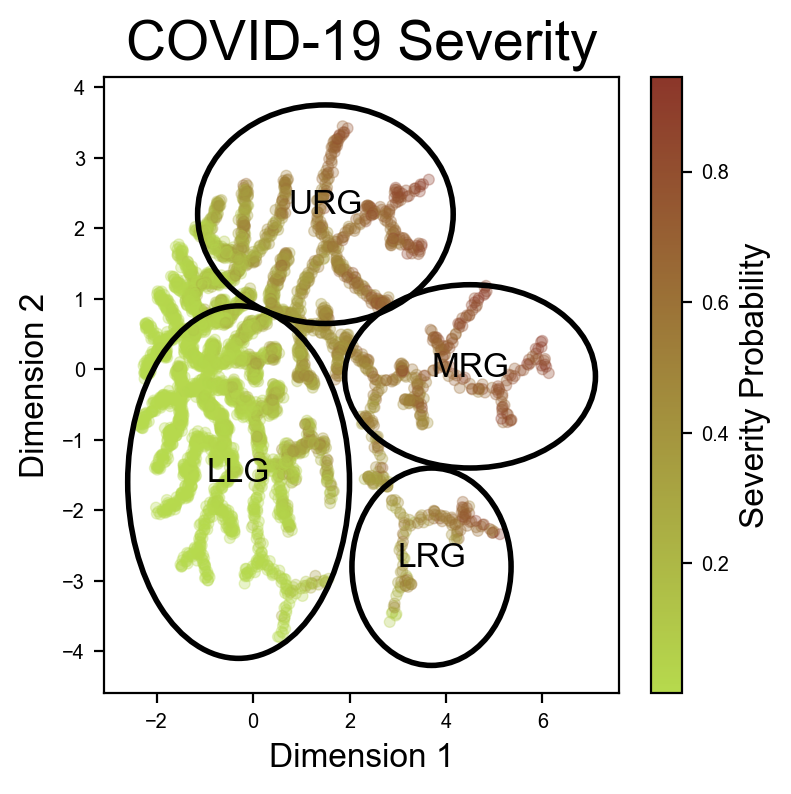

In [159]:
plot_DDR_label(DDR_Tree_Final, Df_DDR_Without_Outliers['severity_proba'], jitter, alpha_level, point_size)

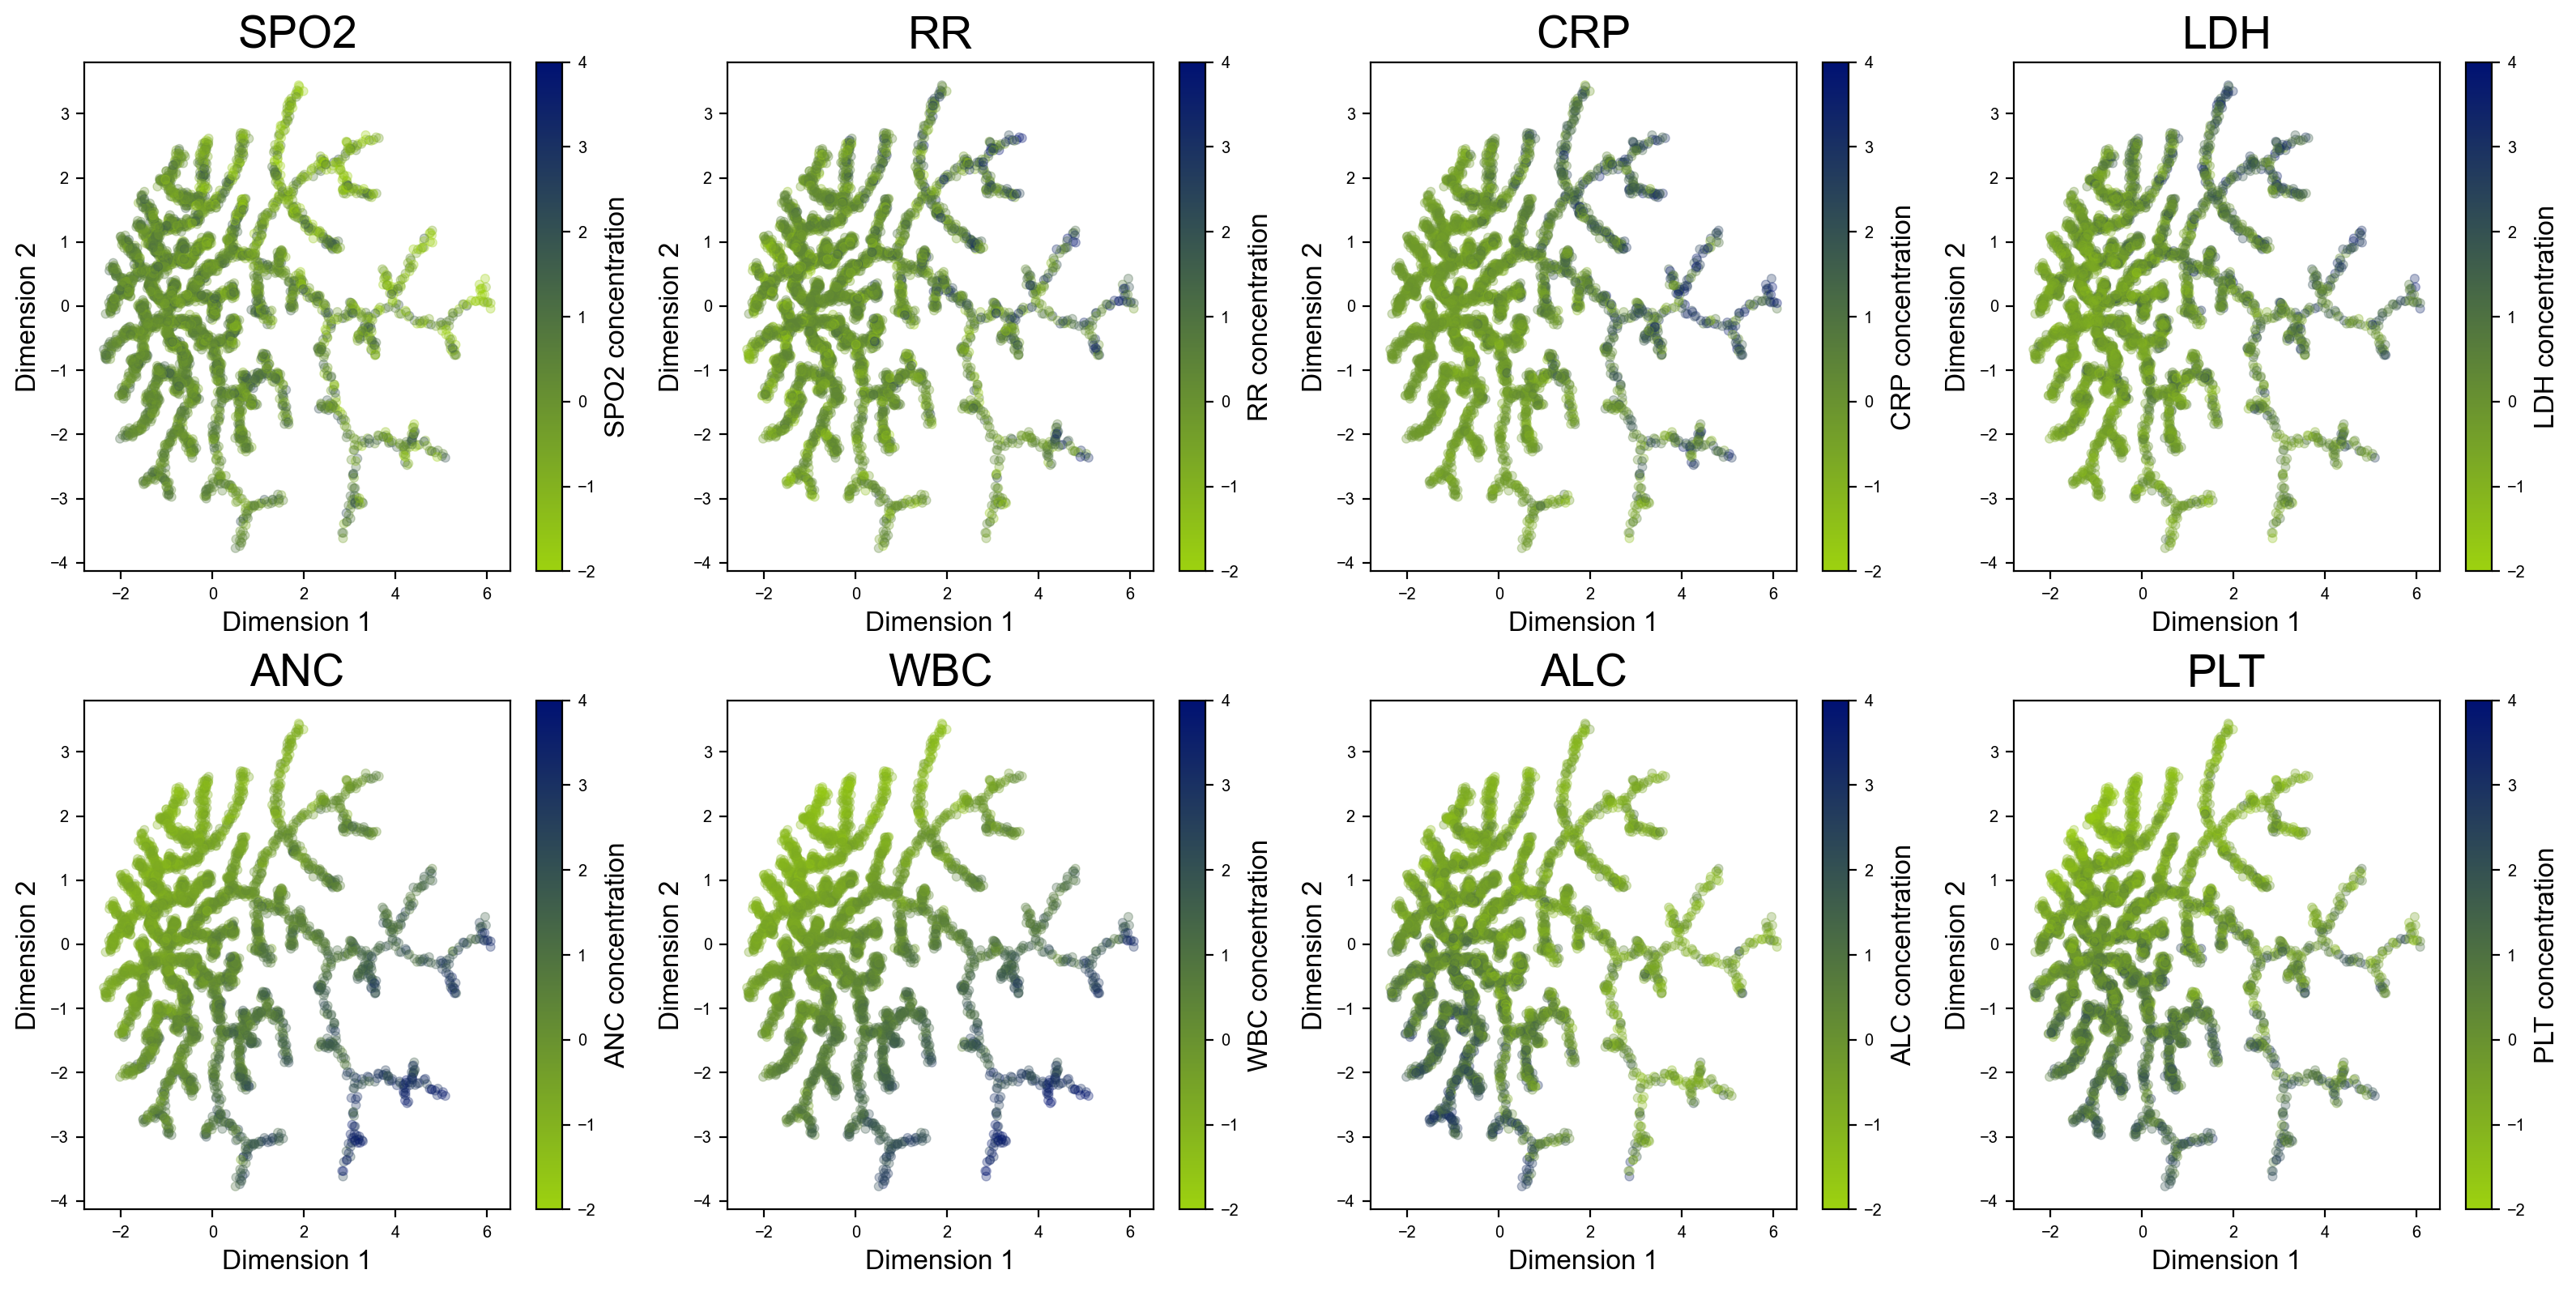

In [96]:
plot_DDR_color(DDR_Tree_Final, residuals_Without_Outliers, lab_vars, jitter, alpha_level, point_size)

#### Plot DDR Tree for Categorical variables

In [19]:
def plot_DDR_label_categorical(DDR, severity, categorical_list, jitter, alpha_level, point_size):
    # Unpack DDRTree's output
    Z, Y_orig, stree, R, W, Q, C, objs = DDR

    # Copy Y to avoid modifying the original data
    Y = Y_orig.copy()
    
    # Transpose Y for easier plotting
    Y = Y.T

    # Add some random noise ("jitter") to the Y values for visualization purposes
    Y += np.random.normal(0, jitter, Y.shape)
    
    # Define color 
    color_list = ['#B6DA4D', '#8C362A']
    
    # Create a colormap from color list
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", color_list, N=256)
    
    fig, axs = plt.subplots(2, 3, figsize=(15,10))  # create 2x3 grid of subplots

    # Add some random noise ("jitter") to the Y values for visualization purposes
    Y += np.random.normal(0, jitter, Y.shape)
    
    color_list = ['lightgray', 'lightgray']
    
    ax_counter = 0  
    for switch in [0, 1]:
        for categorical in categorical_list:
            ax = axs.flatten()[ax_counter]

            # Define categorical_type
            if categorical.name == 'age_category':
                categorical_type = 'Age < 60' if switch == 1 else 'Age ≥ 60'
            else:
                categorical_type = 'Without' if switch == 1 else 'With'
                
            # Create mask for categorical
            mask_categorical = (categorical == switch)

            # Plot patients in corresponding color based on switch for categorical 
            ax.scatter(Y[mask_categorical, 0], Y[mask_categorical, 1], c=color_list[switch], alpha=alpha_level, s=point_size)

            # Plot patients within the color scheme for ~mask_categorical
            sc = ax.scatter(Y[~mask_categorical, 0], Y[~mask_categorical, 1], c=severity[~mask_categorical], alpha=alpha_level, cmap=custom_cmap, s=point_size)

            # Create a separate scatter plot (invisible) just for the colorbar
            sc_colorbar = ax.scatter(Y[:, 0], Y[:, 1], c=severity, alpha=1.0, cmap=custom_cmap, s=0)  
            
            colorbar = fig.colorbar(sc_colorbar, ax=ax)
            colorbar.set_label('Severity Probability', fontsize=12)
            
            ax.set_xlabel('Dimension 1', fontsize=12) 
            ax.set_ylabel('Dimension 2', fontsize=12) 
            if categorical.name =='age_category':
                ax.set_title(f'{categorical_type}', fontsize=20) 
            else:
                ax.set_title(f'{categorical_type} {categorical.name}', fontsize=20) 
            
            ax_counter += 1 
            
    plt.tight_layout()
    plt.savefig("../Result/Figure_6B.png", dpi=600)
    plt.show()

In [70]:
# One-hot encoding age by setting age > 60 as 1, age <= 60 as 0
Df_DDR_Without_Outliers['age_category'] = FinalAll_no_outliers['age'].apply(lambda x: 1 if x > 60 else 0)
Df_DDR_Without_Outliers['age_category'] = Df_DDR_Without_Outliers['age_category'].astype(int)
categorical_variables_1 = [Df_DDR_Without_Outliers['dyspnea'], Df_DDR_Without_Outliers['DM'], Df_DDR_Without_Outliers['age_category']]

# Define jitter, alpha_level, point_size
jitter = 0.04
alpha_level = 0.3
point_size = 20

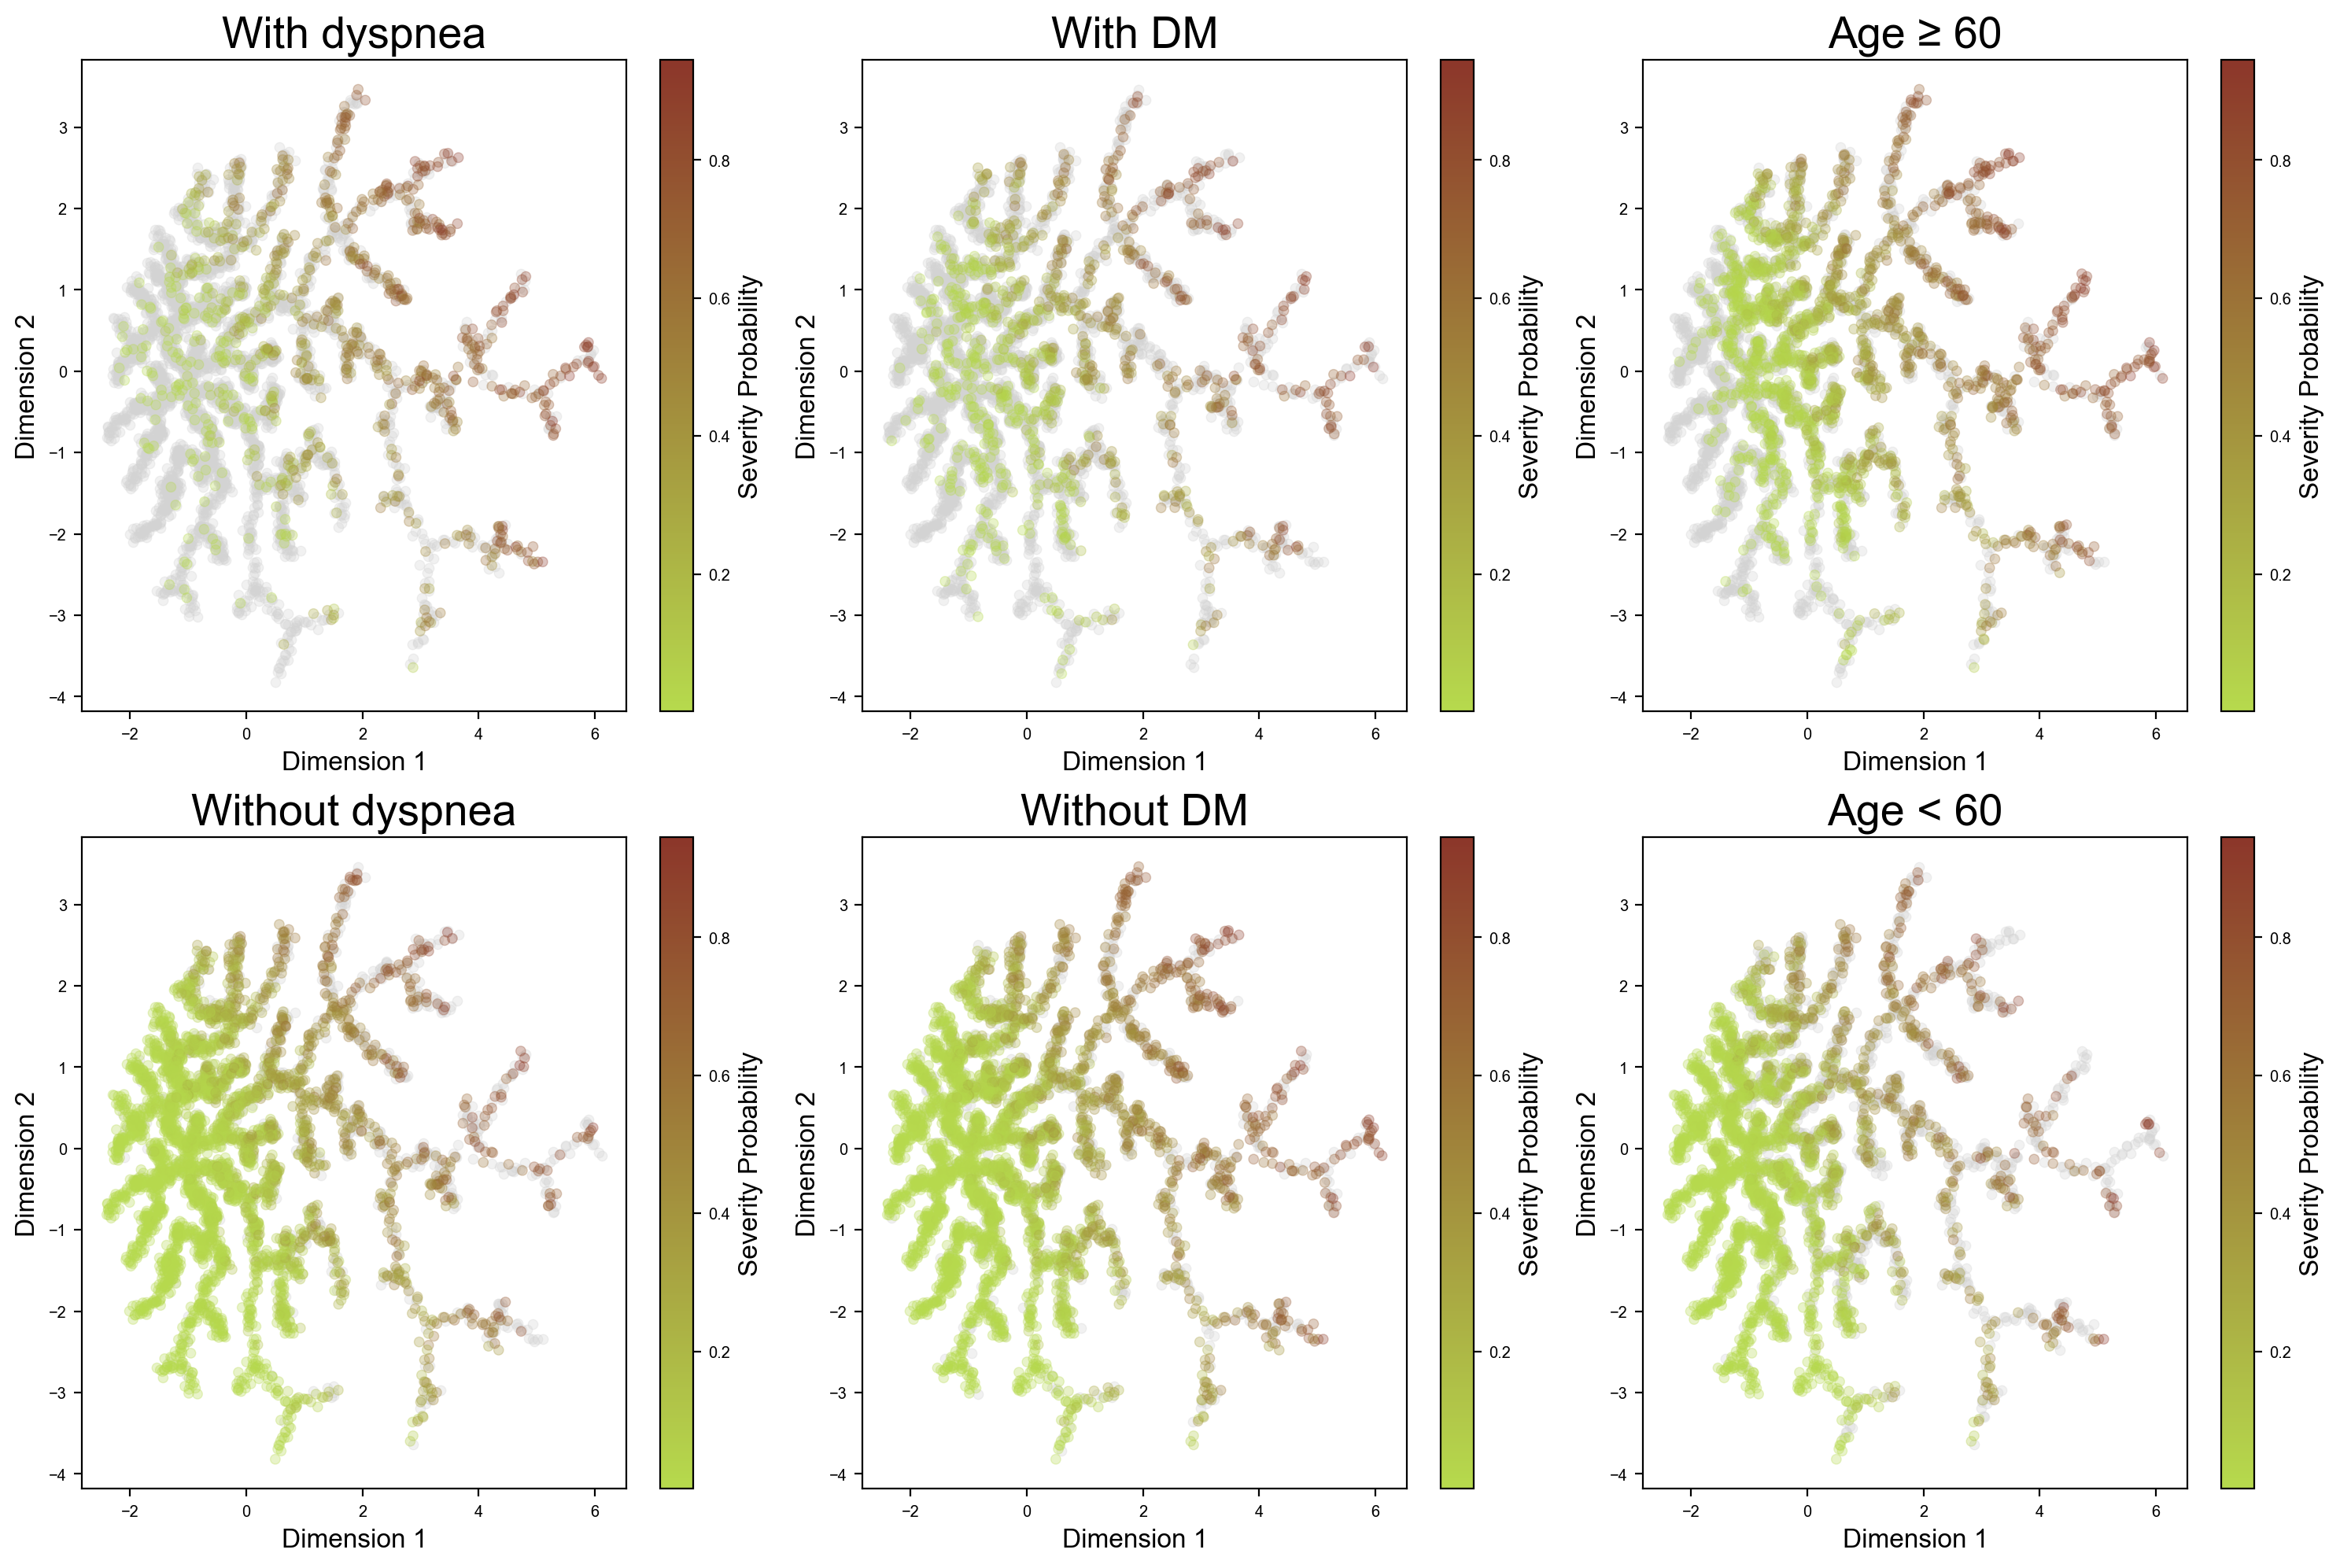

In [71]:
plot_DDR_label_categorical(DDR_Tree_Final, Df_DDR_Without_Outliers['severity_proba'], categorical_variables_1, jitter=jitter, alpha_level=alpha_level, point_size=point_size)

#### COVID variant DDR TREE

In [ ]:
def plot_DDR_variant_one(DDR, variant_column, jitter, alpha_level, point_size):
    # Unpack DDRTree's output
    Z, Y_orig, stree, R, W, Q, C, objs = DDR

    # Copy Y to avoid modifying the original data
    Y = Y_orig.copy()
    
    # Transpose Y for easier plotting
    Y = Y.T
    
    # Add some random noise ("jitter") to the Y values for visualization purposes
    Y += np.random.normal(0, jitter, Y.shape)
    
    # Define color 
    color_list = ['#9DD20F', '#001173', '#FF5733'] # Add more colors if you have more variants
    fig, ax = plt.subplots(figsize=(4, 4))

    variants = ['Original-Alpha', 'Delta', 'Omicron'] 

    for i, variant in enumerate(variants):
        # Create mask for variant
        mask_variant = (variant_column == variant)

        # Plot patients in corresponding color based on variant
        ax.scatter(Y[mask_variant, 0], Y[mask_variant, 1], c=color_list[i], alpha=alpha_level-0.1, s=point_size, label=variant)

    ax.legend(loc='lower right')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_title('All Variants')
    plt.show()

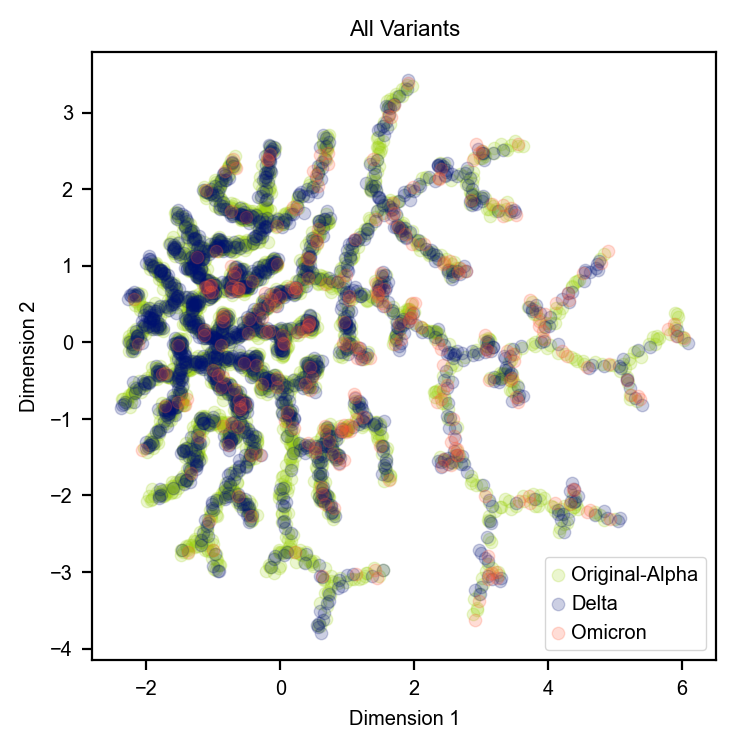

In [44]:
plot_DDR_variant_one(DDR_Tree_Final, FinalAll_no_outliers['variant'], jitter=jitter, alpha_level=alpha_level, point_size=point_size)

In [45]:
def plot_DDR_variant(DDR, variant_column, jitter, alpha_level, point_size):
    # Unpack DDRTree's output
    Z, Y_orig, stree, R, W, Q, C, objs = DDR

    # Copy Y to avoid modifying the original data
    Y = Y_orig.copy()
    
    # Transpose Y for easier plotting
    Y = Y.T
    
    # Add some random noise ("jitter") to the Y values for visualization purposes
    Y += np.random.normal(0, jitter, Y.shape)

    variants = ['Original-Alpha', 'Delta', 'Omicron'] 
    # color_list = ['#9DD20F', '#001173', '#FF5733']  # colors for each variant
    color_list = ['#FF5733', '#FF5733', '#FF5733']
    gray = '#BDC3CB'  

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # create a subplot for each variant

    for i, ax in enumerate(axs):
        for j, variant in enumerate(variants):
            # Create mask for variant
            mask_variant = (variant_column == variant)

            # If current variant matches the subplot, color it distinctly, else gray it out with lower alpha
            color = color_list[i] if i == j else gray
            alpha = alpha_level if i == j else alpha_level-0.1

            # Plot patients in corresponding color based on variant
            ax.scatter(Y[mask_variant, 0], Y[mask_variant, 1], c=color, alpha=alpha, s=point_size, label=variant)
        
        # ax.legend(loc='lower right')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_title(f'{variants[i]}')

    plt.tight_layout()
    plt.show()

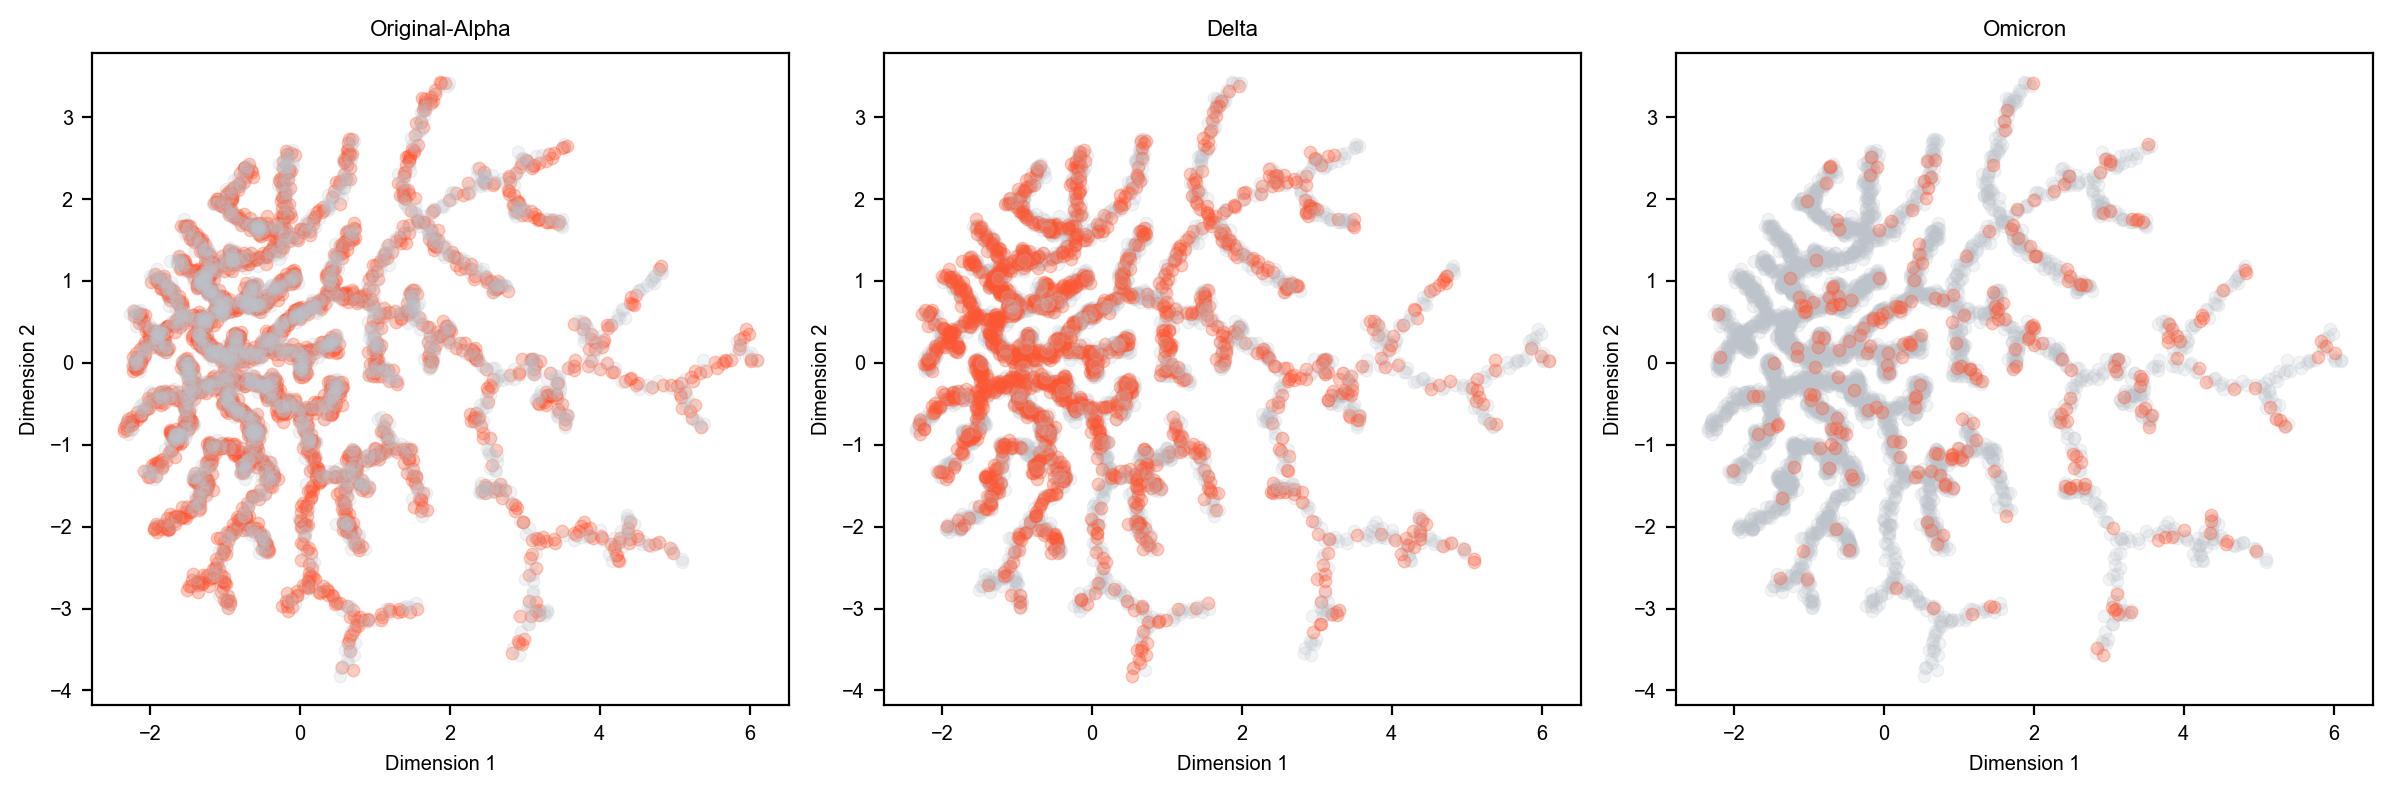

In [46]:
plot_DDR_variant(DDR_Tree_Final, FinalAll_no_outliers['variant'], jitter=jitter, alpha_level=alpha_level, point_size=point_size)

In [28]:
def plot_DDR_variant_severity(DDR, severity, variant_column, jitter, alpha_level, point_size):
    # Unpack DDRTree's output
    Z, Y_orig, stree, R, W, Q, C, objs = DDR

    # Copy Y to avoid modifying the original data
    Y = Y_orig.copy()
    
    # Transpose Y for easier plotting
    Y = Y.T
    
    # Add some random noise ("jitter") to the Y values for visualization purposes
    Y += np.random.normal(0, jitter, Y.shape)

    variants = ['Original-Alpha', 'Delta', 'Omicron']
    gray = '#BDC3CB'  

    # Define color 
    color_list = ['#B6DA4D', '#8C362A']
    
    # Create a colormap from color list
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", color_list, N=256)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # create a subplot for each variant

    for i, variant in enumerate(variants):
        ax = axs[i]  # get the corresponding axis
        
        # Create mask for variant
        mask_variant = (variant_column == variant)

        # Plot patients not in the current variant category in gray
        ax.scatter(Y[~mask_variant, 0], Y[~mask_variant, 1], c=gray, alpha=alpha_level-0.1, s=point_size)

        # Plot patients in the current variant category, color-coded by severity
        sc = ax.scatter(Y[mask_variant, 0], Y[mask_variant, 1], c=severity[mask_variant], alpha=alpha_level, s=point_size, cmap=custom_cmap)

        # Create a separate scatter plot (invisible) just for the colorbar
        sc_colorbar = ax.scatter(Y[:, 0], Y[:, 1], c=severity, alpha=1.0, cmap=custom_cmap, s=0)

        fig.colorbar(sc_colorbar, ax=ax, label='Severity Probability')

        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_title(variant)

    plt.tight_layout()
    plt.show()

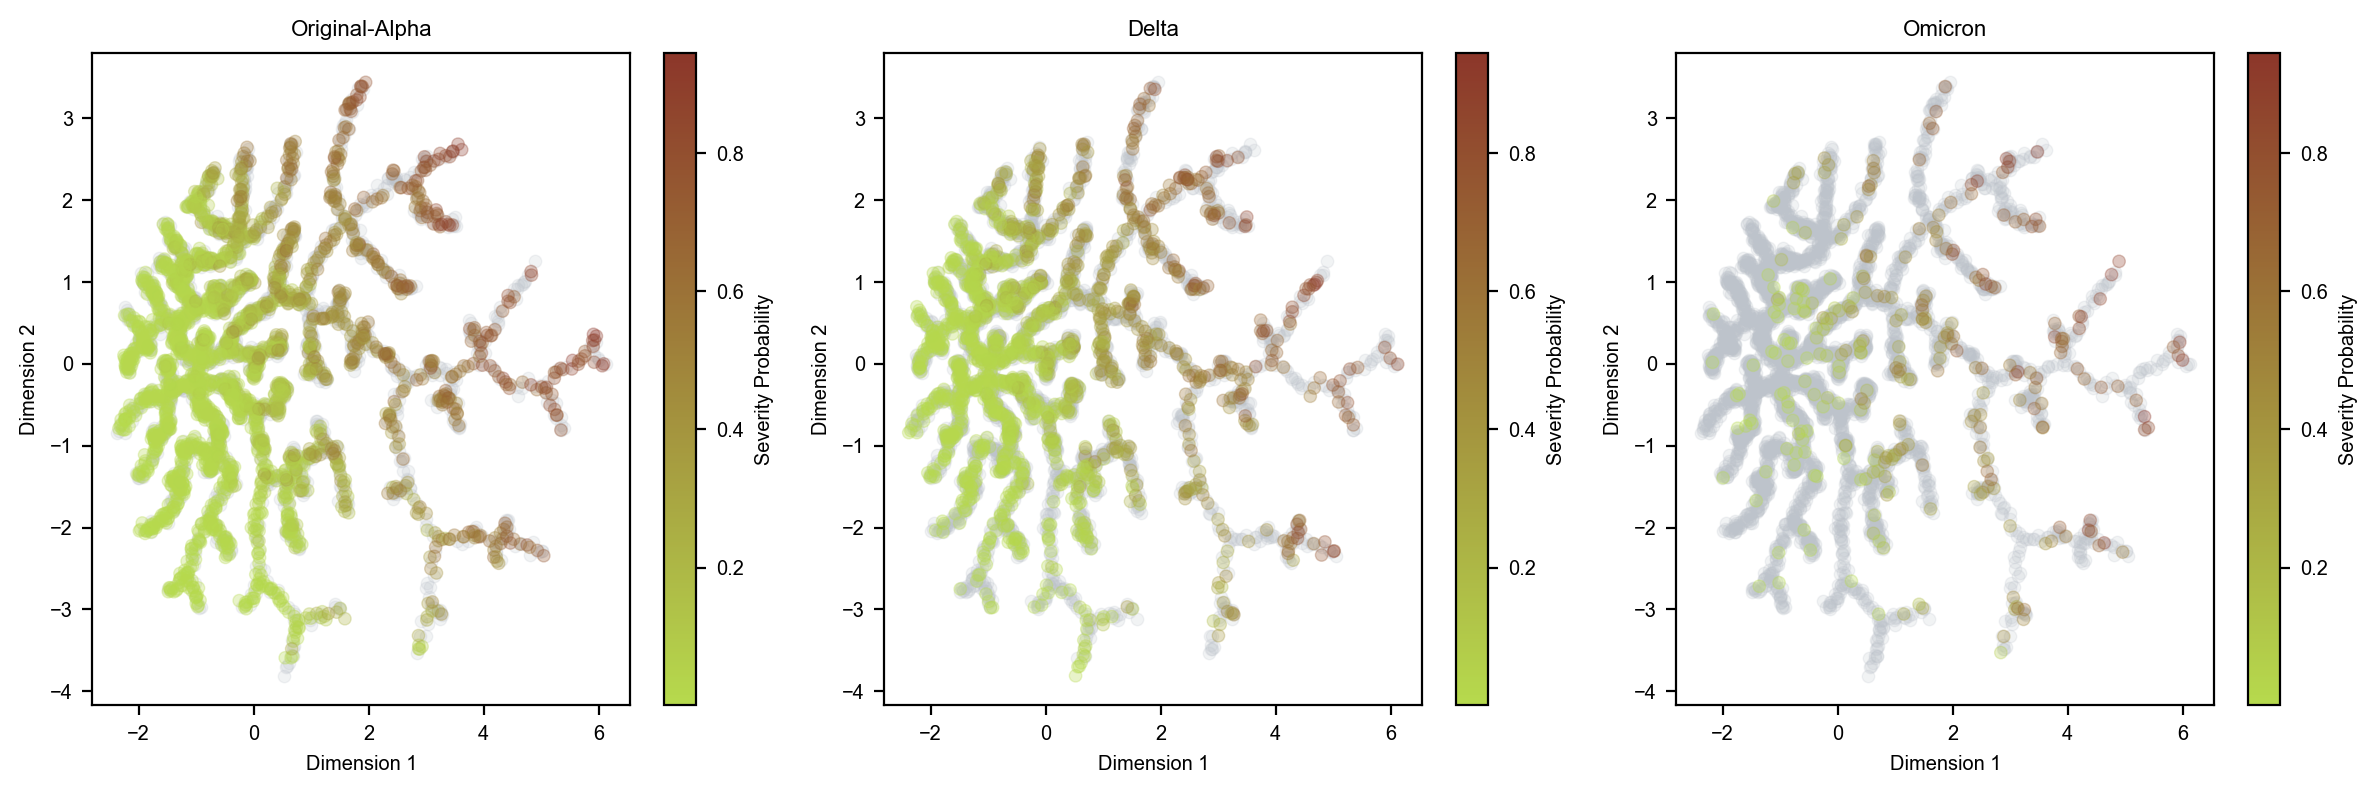

In [29]:
plot_DDR_variant_severity(DDR_Tree_Final, Df_DDR_Without_Outliers['severity_proba'], FinalAll_no_outliers['variant'], jitter=jitter, alpha_level=alpha_level, point_size=point_size)